In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime 
from pandas_datareader import data as pdr
import pandas_ta as ta

In [4]:
# data = dataframe in pandas format to calculate sma
# sma_value = is an array to calcuate the lenth of sma 
# variable = variable used to calculate sma, it can be a "Close", or "Adj Close" in string format
import yfinance as yf
def sma(data,sma_value,variable):
     # auto assign a variable name based on length of sma 
    variable_name = 'SMA'+ str(sma_value)
    # calculate sma 
    data[variable_name] =ta.sma(data[variable], length=sma_value)
    # return sma variable calculated 
    return data[variable_name]
# sym =  string format, ticker name
# ema value = is an array to calcuate the lenth of ema 
# sma_value = is an array to calcuate the lenth of sma 
# close = variable use for calcuate sma and ema, either "Close"or "Adj Close" in string format
def getdata(sym,sma_value,ema_value,close):
    yf.pdr_override()
    today = datetime.datetime.now()
    df = pdr.get_data_yahoo(sym, start=datetime.datetime(today.year-5,today.month, 1),
                                    end=datetime.datetime(today.year, today.month, today.day)).reset_index()
    df['ticker'] =sym
        
    for i in sma_value:
        variable_name = 'SMA'+ str(i)
        df[variable_name] = sma(df,i,close)
    
    for i in ema_value:
        variable_name = 'EMA'+ str(i)
        df[variable_name] = ema(df,i,close)
        
    return df
# data = dataframe in pandas format to calculate ema
# ema_value = is an array to calcuate the lenth of ema 
# variable = variable used to calculate sma, it can be a "Close", or "Adj Close" in string format
def ema(data,ema_value,variable):
    # auto assign a variable name based on length of ema 
    variable_name = 'EMA'+ str(ema_value)
    # calculate ema 
    data[variable_name] = data[variable].ewm(span=ema_value, adjust=False).mean()
     # return ema variable calculated 
    return data[variable_name]

In [111]:
# data = dataframe with price,sma and ema value
# sma_selected = SMA period used to trigger signal
# ema_selected = EMA period used to trigger signal
def Generate_signal(data, sma_selected,ema_selected):    
    #table start
    df_init =  data.copy()
    
    '''To make sure row arrange in an ascending order'''
    df_init.sort_values(by = 'Date',inplace=True)
    
    '''Process data by remove Null value in moving average varaible that your want to used for triggered''' 
    df_init.dropna(subset=[ema_selected,sma_selected],inplace=True)
    '''generate as 1 if Adj close is higher than variable you want to test, generate as -1 if Adj close is less than the
    variable you want to test in a signal variable  
    '''
    # create a signal variable
    df_init['signal'] = np.nan 
    # trigger a buy only if sma selected > ema selected
    #df_init.loc[(df_init['Adj Close']>=df_init[sma_selected]) &(df_init[sma_selected]>=df_init[ema_selected]) ,'signal'] = 1
    df_init.loc[(df_init[sma_selected]>=df_init[ema_selected]) ,'signal'] = 1
    
    # triggered a sell if sma < ema selected
    df_init.loc[(df_init[sma_selected]<df_init[ema_selected]),'signal'] = -1
    #df_init.loc[(df_init['Adj Close']<df_init[sma_selected]),'signal'] = -1
    
    # let it be do nothing if not meet any condition
    df_init['signal'].fillna(0,inplace=True) 
    
    ''' move the signal of today to tmr, thus, we need to define a shift(1), as the signal buy is based on yesterday'''
    df_init['signal'] = df_init['signal'].shift(1)
    
    '''after we have a buy and sell signal, lets create a hold signal which is equal to 2 after a buy signal and
    a do nothing signal which is equal to 0 after a sell signal'''
    
    # In order to make a decision on a hold or do nothing signal based on yesterday signal we need to create a for loop 
    # a calendar date should be created to used for a a for loop 
    date_list = df_init.Date.unique()
    
    # declare a first day, the first date is a null in signal as there is no yesterday data for first data
    first_date = date_list[0]
    
    # declare a previous day 
    prev = first_date 
    
    for i in date_list:
        if i == first_date:
            df_init.loc[df_init.Date == i,'signal'] = 0 
        else:
            # if you have a sell signal yesterday, you should have a do nothing signal today
            if (df_init.loc[df_init.Date == prev,'signal'].values[0]==-1):
                df_init.loc[df_init.Date == i,'signal']=0 
            # if you have a buy signal yesterday, you should have a hold signal today
            elif (df_init.loc[df_init.Date == prev,'signal'].values[0]==1):
                df_init.loc[df_init.Date == i,'signal'] = 2
              
            # if you have a hold signal yesterday and you do not have a sell signal today, you should have a hold signal today
            elif ((df_init.loc[df_init.Date == prev,'signal'].values[0]==2)&(df_init.loc[df_init.Date == i,'signal'].values[0]!=-1) ):
                df_init.loc[df_init.Date == i,'signal'] = 2
                
            # if you have a do nothing signal yesterday and today is a sell signal, you should equal to have a do nothing signal
            elif ((df_init.loc[df_init.Date == prev,'signal'].values[0]==0)&(df_init.loc[df_init.Date == i,'signal'].values[0]==-1) ):
                df_init.loc[df_init.Date == i,'signal'] = 0
                
        # redeclare your previous date before to next day in for loop
        prev = i
    
    return df_init

In [112]:
# data = dataframe with signal to trigger
# capital = assume starting capital
# result data = to store win chance, average lost and other statistic data
from statistics import mean
def backtest_strategy(data,capital, result_data):   
    
    #table start
    df_init =  data.copy()
    df_init.set_index('Date',inplace=True) 
    
    #assign dummy row - day before the trade
    start_date = pd.DataFrame(columns=data.columns,index=[df_init.index.min()- datetime.timedelta(days=1)])
    df_init = df_init.append(start_date)
    
    #initiat 2 variable: cash and units which represent each status of cash and units of apple holding for each day
    df_init = df_init.assign(cash=np.nan,units = 0)
    
    #assign capital for first dummy day assigned to be capital defined in function
    df_init.loc[pd.Series(df_init.index.min()), 'cash'] = capital
    
    # obtain list of calendar 
    calendar = pd.Series(df_init.index.sort_values().unique()).iloc[1:]
    
    ''' assign a variable which is trade, earn trade and lost trade to calculate total number of trade, total earn trade 
    and total lost trade'''
    trade = 0
    earn_trade = 0
    loss_trade = 0
    
    ''' create an array to keep all earn value and lost value for each trade'''
    earn_value =[]
    lost_value =[]

    for date in calendar:
        
        #get yesterday data
        prev_date = df_init.index[df_init.index<date].unique().sort_values()[-1]
        
        # calculate total stock value of yesterday 
        stock_holding = df_init.loc[(df_init.index==prev_date), 'units'].values[0]*df_init.loc[(df_init.index==date),'Price'].values[0]
        
        # total portfolio value by add cash and stock value of yesterday 
        port_value = stock_holding + df_init.loc[prev_date, 'cash'].sum()
        
        
        # if signal is do nothing, mean our cash = portfolio value and units=0
        if df_init.loc[(df_init.index==date), 'signal'].values[0] == 0:          
            df_init.loc[(df_init.index==date), 'units'] = 0
            df_init.loc[(df_init.index==date), 'cash'] =port_value        
        #if we have a buy signal 
        #start to calculate the trade
        #we start to calculate start_cap which represent the starting capital for each trade
        #unit_buy is total unit buy based on port_value available
        elif df_init.loc[(df_init.index==date), 'signal'].values[0] == 1:
            trade+=1
            start_cap = port_value 
            unit_buy = port_value/df_init.loc[(df_init.index==date), 'Price'].values[0]
            df_init.loc[(df_init.index==date), 'units'] = unit_buy
            df_init.loc[(df_init.index==date), 'cash'] = port_value - unit_buy*df_init.loc[(df_init.index==date), 'Price'].values[0]        
#             df_init.loc[(df_init.index==date), 'CL_price'] = df_init.loc[(df_init.index==date), 'Price'].values[0] * 0.95
#             df_init.loc[(df_init.index==date), 'CL_based_price'] = df_init.loc[(df_init.index==date), 'Price'].values[0]
        #if we have a hold signal or do nothing signal,
        #mean today units hold and cash are same as yesterday units hold and yesterday cash
        elif ((df_init.loc[(df_init.index==date), 'signal'].values[0] == 2) | (df_init.loc[(df_init.index==date), 'signal'].values[0] == 0)): 
            df_init.loc[(df_init.index==date), 'units'] = df_init.loc[(df_init.index==prev_date), 'units'].values[0]
            df_init.loc[(df_init.index==date), 'cash'] =df_init.loc[(df_init.index==prev_date), 'cash'].values[0]
#             if  df_init.loc[(df_init.index==date), 'Price'].values[0] > df_init.loc[(df_init.index==prev_date), 'CL_based_price'].values[0]:
#                 df_init.loc[(df_init.index==date), 'CL_price'] = df_init.loc[(df_init.index==date), 'Price'].values[0] * 0.95
#                 df_init.loc[(df_init.index==date), 'CL_based_price'] = df_init.loc[(df_init.index==date), 'Price'].values[0]
#             else:
#                 df_init.loc[(df_init.index==date), 'CL_price'] = df_init.loc[(df_init.index==prev_date), 'CL_price'].values[0]
#                 df_init.loc[(df_init.index==date), 'CL_based_price'] =  df_init.loc[(df_init.index==prev_date), 'CL_based_price'].values[0]
        #if we have a sell signal,
        #1. we sell all the units at the today open price and thus units =0 and cash = port_value
        #2. we calculate the total earn/lost of this trade by using port_value - start cap of the trade and store as v variable
        #3. if v> 0, we store as earn_value array
        #4. if v<0, we store as lost trade
        elif (df_init.loc[(df_init.index==date), 'signal'].values[0] == -1) :
            df_init.loc[(df_init.index==date), 'units'] = 0
            df_init.loc[(df_init.index==date), 'cash'] =port_value 
            if (start_cap is None):
                0
            else:
                v = port_value  - start_cap 
                if v>= 0: 
                    earn_value.append(v)
                    earn_trade +=1
                elif v<0: 
                    lost_value.append(v)
                    loss_trade+=1

    # calculate current value of the strategy, the formula = unit holding * Price + cash available
    df_init['Total_value_todate'] = df_init['units']*df_init['Price'] + df_init['cash'] 
    
    # append 0 to earn value array to prevent later calculation fail if there is no any earn trade
    earn_value.append(0)
    #remove dummy rows
    df_init.drop(df_init[df_init.index == df_init.index.min()].index,axis=0,inplace=True)
  
    # get summarize of total portfolio value, return by date, benchmark_index
    total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate'].sum())
    total_port_value['Return_without_trailing'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].iloc[0] *100
    total_port_value['Return_trailing_12m'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].shift(12)*100

    # to print out statistic to know how your strategy perform and the win change of this strategy
    print('total_trade:',trade)
    print('earn_trade:',earn_trade)
    print('lost_trade:',loss_trade)
    print('win_chance:',earn_trade/trade)
    print('Max earning:',max(earn_value))
    print('Max lost:',min(lost_value))
    print('Average lost:',mean(lost_value))
    print('Average Win:',mean(earn_value))
    # Create a dictionary with the data for the new data frame
    data = {
        'ticket': [data.ticker.values[0]],
        'total_trade' : [trade],
        'Average Win': [mean(earn_value)],
        'Average lost' :  [mean(lost_value)],
        'win_chance': [earn_trade/trade]
    }

    # Create the new data frame
    df = pd.DataFrame(data)
    result_data =  pd.concat([df , result_data])
    return total_port_value, df_init,result_data

In [113]:
# annualized return 
# df =data with return 
# variable = variable name of return
def annualized(df,variable):
    days_held =df.shape[0]
    Return = (df.iloc[-1][variable] - df.iloc[0][variable])/df.iloc[0][variable]
    ar = ((1+Return) ** (365/days_held))-1
    # get annualized in %
    return ar*100
# maximum drawdown 
# df =data with return 
# variable = variable name of return
def MDD(df,variable):
    window = 252
    Roll_Max = df[variable].rolling(window, min_periods=1).max()
    Drawdown = df[variable]/Roll_Max - 1.0
    mdd = Drawdown.min()
    # get drawdown in %
    return mdd*100

In [114]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
ticker = df['Symbol'].values
result_data = pd.DataFrame()

In [106]:
for i in ticker:
    # Read in the data
    try:
        print(i)
        sma_ = [5,10,15,20,50,60,120,150,200]
        ema_ = [5,10,15,20,50,60,120,150,200]
        data = getdata(i,sma_value = [5,10,15,20,50,60,120,150,200],ema_value = [5,10,15,20,50,60,120,150,200],close = "Close")
        #data['RSI'] = RSI(data['Close'])
        #data  = macd(data)
        # Get signal
        df_signal = Generate_signal(data,'SMA15','EMA15')
        # back test your strategy using Open price as price action to buy sell on particular day
        df_signal['Price']=df_signal['Open']
        df_backtest = df_signal[['Date','Price','signal','Open','ticker']].copy()
        result, hold_detail,result_data = backtest_strategy(df_backtest,1000,result_data)
    except:
        pass # doing nothing on exception

MMM
[*********************100%***********************]  1 of 1 completed
total_trade: 53
earn_trade: 28
lost_trade: 24
win_chance: 0.5283018867924528
Max earning: 65.22384413558007
Max lost: -182.0769510446479
Average lost: -43.449278917519436
Average Win: 20.790285808702752
AOS
[*********************100%***********************]  1 of 1 completed
total_trade: 53
earn_trade: 32
lost_trade: 21
win_chance: 0.6037735849056604
Max earning: 147.03181177607348
Max lost: -226.44565277306765
Average lost: -66.04759101999096
Average Win: 38.296812921721255
ABT
[*********************100%***********************]  1 of 1 completed
total_trade: 56
earn_trade: 40
lost_trade: 15
win_chance: 0.7142857142857143
Max earning: 251.53460359249584
Max lost: -186.7721482979082
Average lost: -68.0494973087058
Average Win: 47.55204005919969
ABBV
[*********************100%***********************]  1 of 1 completed
total_trade: 56
earn_trade: 35
lost_trade: 20
win_chance: 0.625
Max earning: 101.64019543947256
Max

[*********************100%***********************]  1 of 1 completed
total_trade: 54
earn_trade: 34
lost_trade: 19
win_chance: 0.6296296296296297
Max earning: 69.53412273009326
Max lost: -289.2554673589127
Average lost: -57.08006374628651
Average Win: 33.83730335533121
AXP
[*********************100%***********************]  1 of 1 completed
total_trade: 51
earn_trade: 34
lost_trade: 16
win_chance: 0.6666666666666666
Max earning: 187.30851789091548
Max lost: -392.0456599482445
Average lost: -70.62165756206124
Average Win: 56.53108497252903
AIG
[*********************100%***********************]  1 of 1 completed
total_trade: 54
earn_trade: 36
lost_trade: 17
win_chance: 0.6666666666666666
Max earning: 119.9626500794883
Max lost: -612.0668994353317
Average lost: -80.26140932317733
Average Win: 35.01764809301978
AMT
[*********************100%***********************]  1 of 1 completed
total_trade: 48
earn_trade: 28
lost_trade: 19
win_chance: 0.5833333333333334
Max earning: 123.88629809621557

[*********************100%***********************]  1 of 1 completed
total_trade: 56
earn_trade: 37
lost_trade: 18
win_chance: 0.6607142857142857
Max earning: 166.42659023713736
Max lost: -482.3000569404144
Average lost: -123.92114827615588
Average Win: 66.24607941637255
BAX
[*********************100%***********************]  1 of 1 completed
total_trade: 58
earn_trade: 37
lost_trade: 20
win_chance: 0.6379310344827587
Max earning: 73.02327574645619
Max lost: -208.26942898485925
Average lost: -47.923800096619836
Average Win: 37.12196513932457
BDX
[*********************100%***********************]  1 of 1 completed
total_trade: 54
earn_trade: 32
lost_trade: 21
win_chance: 0.5925925925925926
Max earning: 56.134196802129054
Max lost: -117.15916901570802
Average lost: -38.69927356756181
Average Win: 23.71615240028681
WRB
[*********************100%***********************]  1 of 1 completed
total_trade: 56
earn_trade: 37
lost_trade: 19
win_chance: 0.6607142857142857
Max earning: 141.899747605

[*********************100%***********************]  1 of 1 completed
total_trade: 51
earn_trade: 29
lost_trade: 22
win_chance: 0.5686274509803921
Max earning: 158.2889617287326
Max lost: -242.87876824871614
Average lost: -78.9041355100443
Average Win: 67.33688881056602
CAT
[*********************100%***********************]  1 of 1 completed
total_trade: 51
earn_trade: 32
lost_trade: 19
win_chance: 0.6274509803921569
Max earning: 61.73284283287569
Max lost: -152.79243545653924
Average lost: -55.47468635151905
Average Win: 26.806380664601924
CBOE
[*********************100%***********************]  1 of 1 completed
total_trade: 59
earn_trade: 36
lost_trade: 23
win_chance: 0.6101694915254238
Max earning: 43.751507308599685
Max lost: -205.97664092876653
Average lost: -36.959119138457005
Average Win: 15.949725575329117
CBRE
[*********************100%***********************]  1 of 1 completed
total_trade: 53
earn_trade: 37
lost_trade: 15
win_chance: 0.6981132075471698
Max earning: 134.2644030

[*********************100%***********************]  1 of 1 completed
total_trade: 53
earn_trade: 32
lost_trade: 21
win_chance: 0.6037735849056604
Max earning: 64.92805139289419
Max lost: -295.5758953958606
Average lost: -56.25599644502094
Average Win: 28.194769707878297
CAG
[*********************100%***********************]  1 of 1 completed
total_trade: 51
earn_trade: 32
lost_trade: 18
win_chance: 0.6274509803921569
Max earning: 152.63519482497713
Max lost: -276.57354582959124
Average lost: -57.051479554218915
Average Win: 28.01704517760527
COP
[*********************100%***********************]  1 of 1 completed
total_trade: 56
earn_trade: 34
lost_trade: 22
win_chance: 0.6071428571428571
Max earning: 140.66457757199805
Max lost: -328.9356502099213
Average lost: -68.63992891251468
Average Win: 44.72978445973324
ED
[*********************100%***********************]  1 of 1 completed
total_trade: 51
earn_trade: 32
lost_trade: 18
win_chance: 0.6274509803921569
Max earning: 96.766254505297

[*********************100%***********************]  1 of 1 completed
total_trade: 54
earn_trade: 29
lost_trade: 24
win_chance: 0.5370370370370371
Max earning: 196.1594794854052
Max lost: -291.9153223050621
Average lost: -57.96864889138601
Average Win: 40.48121099158127
DG
[*********************100%***********************]  1 of 1 completed
total_trade: 54
earn_trade: 39
lost_trade: 15
win_chance: 0.7222222222222222
Max earning: 148.01755232959113
Max lost: -158.39434243204119
Average lost: -58.318859201013844
Average Win: 42.08740287683586
DLTR
[*********************100%***********************]  1 of 1 completed
total_trade: 51
earn_trade: 30
lost_trade: 21
win_chance: 0.5882352941176471
Max earning: 180.26441748951925
Max lost: -132.45346260148676
Average lost: -56.500436869066824
Average Win: 47.53282239181738
D
[*********************100%***********************]  1 of 1 completed
total_trade: 58
earn_trade: 40
lost_trade: 18
win_chance: 0.6896551724137931
Max earning: 59.890579376655

[*********************100%***********************]  1 of 1 completed
total_trade: 56
earn_trade: 38
lost_trade: 16
win_chance: 0.6785714285714286
Max earning: 115.80277274396667
Max lost: -272.66470679006113
Average lost: -71.64040572604699
Average Win: 43.2441859149742
IT
[*********************100%***********************]  1 of 1 completed
total_trade: 46
earn_trade: 29
lost_trade: 16
win_chance: 0.6304347826086957
Max earning: 86.95883971010977
Max lost: -212.35272500554152
Average lost: -61.80134453871009
Average Win: 25.326427823257866
GEN
[*********************100%***********************]  1 of 1 completed
total_trade: 55
earn_trade: 30
lost_trade: 24
win_chance: 0.5454545454545454
Max earning: 138.47309219988165
Max lost: -293.68614258044465
Average lost: -50.67533860830676
Average Win: 35.31382759212654
GNRC
[*********************100%***********************]  1 of 1 completed
total_trade: 50
earn_trade: 33
lost_trade: 17
win_chance: 0.66
Max earning: 673.964771301371
Max lost: -

[*********************100%***********************]  1 of 1 completed
total_trade: 58
earn_trade: 38
lost_trade: 20
win_chance: 0.6551724137931034
Max earning: 156.75004014145657
Max lost: -343.26132798548906
Average lost: -90.13926701664262
Average Win: 64.9565717884154
HBAN
[*********************100%***********************]  1 of 1 completed
total_trade: 51
earn_trade: 32
lost_trade: 18
win_chance: 0.6274509803921569
Max earning: 48.18522491510748
Max lost: -350.28780743995685
Average lost: -58.76318724252745
Average Win: 23.077956305192494
HII
[*********************100%***********************]  1 of 1 completed
total_trade: 52
earn_trade: 24
lost_trade: 27
win_chance: 0.46153846153846156
Max earning: 129.1117935651273
Max lost: -262.7048113517021
Average lost: -42.36959413641877
Average Win: 29.73077118751874
IBM
[*********************100%***********************]  1 of 1 completed
total_trade: 55
earn_trade: 35
lost_trade: 19
win_chance: 0.6363636363636364
Max earning: 53.53897880897

[*********************100%***********************]  1 of 1 completed
total_trade: 50
earn_trade: 27
lost_trade: 23
win_chance: 0.54
Max earning: 71.56854125420364
Max lost: -460.7491613435894
Average lost: -52.7529477275651
Average Win: 25.868828255164775
KEYS
[*********************100%***********************]  1 of 1 completed
total_trade: 59
earn_trade: 45
lost_trade: 13
win_chance: 0.7627118644067796
Max earning: 170.1076804955228
Max lost: -375.5935969236134
Average lost: -92.85768327674275
Average Win: 60.14786354870982
KMB
[*********************100%***********************]  1 of 1 completed
total_trade: 59
earn_trade: 39
lost_trade: 19
win_chance: 0.6610169491525424
Max earning: 156.1067226373425
Max lost: -130.3641141292096
Average lost: -56.343349587534725
Average Win: 34.99642110569923
KIM
[*********************100%***********************]  1 of 1 completed
total_trade: 62
earn_trade: 43
lost_trade: 18
win_chance: 0.6935483870967742
Max earning: 250.07964627576825
Max lost: -4

[*********************100%***********************]  1 of 1 completed
total_trade: 61
earn_trade: 39
lost_trade: 21
win_chance: 0.639344262295082
Max earning: 102.33711560058237
Max lost: -200.14371114741346
Average lost: -60.58011869849233
Average Win: 34.54986476928065
MAS
[*********************100%***********************]  1 of 1 completed
total_trade: 55
earn_trade: 33
lost_trade: 21
win_chance: 0.6
Max earning: 125.16148481959794
Max lost: -216.553751149175
Average lost: -60.87452286833983
Average Win: 41.19134516960306
MA
[*********************100%***********************]  1 of 1 completed
total_trade: 57
earn_trade: 38
lost_trade: 18
win_chance: 0.6666666666666666
Max earning: 167.37335064939498
Max lost: -368.15688493632274
Average lost: -78.3032295511834
Average Win: 62.733702608386224
MTCH
[*********************100%***********************]  1 of 1 completed
total_trade: 56
earn_trade: 32
lost_trade: 23
win_chance: 0.5714285714285714
Max earning: 302.4082812447514
Max lost: -47

[*********************100%***********************]  1 of 1 completed
total_trade: 60
earn_trade: 39
lost_trade: 21
win_chance: 0.65
Max earning: 300.3817041014345
Max lost: -446.7416074825378
Average lost: -96.27730715747794
Average Win: 77.20655573193382
NFLX
[*********************100%***********************]  1 of 1 completed
total_trade: 61
earn_trade: 39
lost_trade: 21
win_chance: 0.639344262295082
Max earning: 271.09165536950786
Max lost: -957.0458868987254
Average lost: -133.61465759422228
Average Win: 90.40118061672116
NWL
[*********************100%***********************]  1 of 1 completed
total_trade: 53
earn_trade: 30
lost_trade: 22
win_chance: 0.5660377358490566
Max earning: 59.96479230495902
Max lost: -166.9031350783191
Average lost: -53.52656087999857
Average Win: 22.14207347479185
NEM
[*********************100%***********************]  1 of 1 completed
total_trade: 57
earn_trade: 39
lost_trade: 18
win_chance: 0.6842105263157895
Max earning: 261.22940509994487
Max lost: -4

[*********************100%***********************]  1 of 1 completed
total_trade: 52
earn_trade: 28
lost_trade: 23
win_chance: 0.5384615384615384
Max earning: 97.8692337665687
Max lost: -286.6205240232934
Average lost: -73.29688039885008
Average Win: 34.754180482146204
PH
[*********************100%***********************]  1 of 1 completed
total_trade: 54
earn_trade: 36
lost_trade: 17
win_chance: 0.6666666666666666
Max earning: 119.47468116861057
Max lost: -277.3607322051825
Average lost: -70.68499802163777
Average Win: 34.987247626366695
PAYX
[*********************100%***********************]  1 of 1 completed
total_trade: 54
earn_trade: 37
lost_trade: 16
win_chance: 0.6851851851851852
Max earning: 81.78035063994287
Max lost: -302.7509888715091
Average lost: -69.2668595044286
Average Win: 30.724263368304616
PAYC
[*********************100%***********************]  1 of 1 completed
total_trade: 48
earn_trade: 31
lost_trade: 16
win_chance: 0.6458333333333334
Max earning: 243.041708767323

[*********************100%***********************]  1 of 1 completed
total_trade: 50
earn_trade: 30
lost_trade: 20
win_chance: 0.6
Max earning: 75.72912745580265
Max lost: -279.2511034080526
Average lost: -54.24929455527691
Average Win: 25.3909344029341
RL
[*********************100%***********************]  1 of 1 completed
total_trade: 51
earn_trade: 23
lost_trade: 27
win_chance: 0.45098039215686275
Max earning: 97.73479078052014
Max lost: -292.13574401181194
Average lost: -48.01790899491244
Average Win: 41.97180960566685
RJF
[*********************100%***********************]  1 of 1 completed
total_trade: 49
earn_trade: 30
lost_trade: 19
win_chance: 0.6122448979591837
Max earning: 216.4920568653481
Max lost: -224.19630531601592
Average lost: -51.49407575292103
Average Win: 46.25243923962701
RTX
[*********************100%***********************]  1 of 1 completed
total_trade: 56
earn_trade: 35
lost_trade: 20
win_chance: 0.625
Max earning: 107.77884508746865
Max lost: -322.593838941550

[*********************100%***********************]  1 of 1 completed
total_trade: 52
earn_trade: 36
lost_trade: 15
win_chance: 0.6923076923076923
Max earning: 786.0278505676149
Max lost: -687.3247671679965
Average lost: -246.2780149037281
Average Win: 137.57420969154782
SO
[*********************100%***********************]  1 of 1 completed
total_trade: 57
earn_trade: 41
lost_trade: 15
win_chance: 0.7192982456140351
Max earning: 117.91711100560633
Max lost: -290.03973878797456
Average lost: -63.68774524088949
Average Win: 28.535573872635794
LUV
[*********************100%***********************]  1 of 1 completed
total_trade: 50
earn_trade: 26
lost_trade: 23
win_chance: 0.52
Max earning: 122.77596960358335
Max lost: -224.74750056420817
Average lost: -53.15476642632179
Average Win: 38.71406262325758
SWK
[*********************100%***********************]  1 of 1 completed
total_trade: 56
earn_trade: 36
lost_trade: 19
win_chance: 0.6428571428571429
Max earning: 142.30126922734735
Max lost:

[*********************100%***********************]  1 of 1 completed
total_trade: 50
earn_trade: 31
lost_trade: 19
win_chance: 0.62
Max earning: 151.06166128734105
Max lost: -625.8990844966639
Average lost: -84.12035541760328
Average Win: 53.38159418530154
TRV
[*********************100%***********************]  1 of 1 completed
total_trade: 57
earn_trade: 40
lost_trade: 17
win_chance: 0.7017543859649122
Max earning: 94.08870516480658
Max lost: -380.9428677401894
Average lost: -52.86336357776444
Average Win: 31.049817910140472
TRMB
[*********************100%***********************]  1 of 1 completed
total_trade: 59
earn_trade: 41
lost_trade: 17
win_chance: 0.6949152542372882
Max earning: 132.9604518692936
Max lost: -412.88992254736365
Average lost: -109.31501866312313
Average Win: 53.71577598341819
TFC
[*********************100%***********************]  1 of 1 completed
total_trade: 52
earn_trade: 32
lost_trade: 20
win_chance: 0.6153846153846154
Max earning: 62.840165797379086
Max lost:

[*********************100%***********************]  1 of 1 completed
total_trade: 49
earn_trade: 25
lost_trade: 23
win_chance: 0.5102040816326531
Max earning: 204.31447783159388
Max lost: -523.9058794459725
Average lost: -78.05452369594342
Average Win: 45.97141813954459
WM
[*********************100%***********************]  1 of 1 completed
total_trade: 56
earn_trade: 41
lost_trade: 14
win_chance: 0.7321428571428571
Max earning: 81.6253194472929
Max lost: -329.7789684530743
Average lost: -60.56470050184987
Average Win: 31.603296180346018
WAT
[*********************100%***********************]  1 of 1 completed
total_trade: 51
earn_trade: 28
lost_trade: 22
win_chance: 0.5490196078431373
Max earning: 62.29291315109117
Max lost: -157.30227745168077
Average lost: -43.21708287043057
Average Win: 25.003708057837933
WEC
[*********************100%***********************]  1 of 1 completed
total_trade: 51
earn_trade: 31
lost_trade: 19
win_chance: 0.6078431372549019
Max earning: 87.62972110114879

In [108]:
# calculated risk reward ratio
result_data['Risk Reward ratio'] = result_data['Average Win']/abs(result_data['Average lost'])

C:\Users\CHIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Probability')

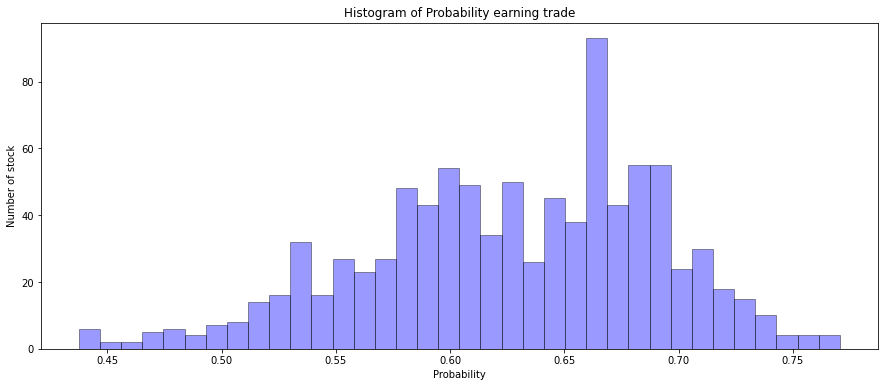

In [109]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
# plot the probability of earning trade
# seaborn histogram
sns.distplot(result_data['win_chance'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Probability earning trade')
plt.ylabel('Number of stock')
plt.xlabel('Probability')

0.6235025958020596


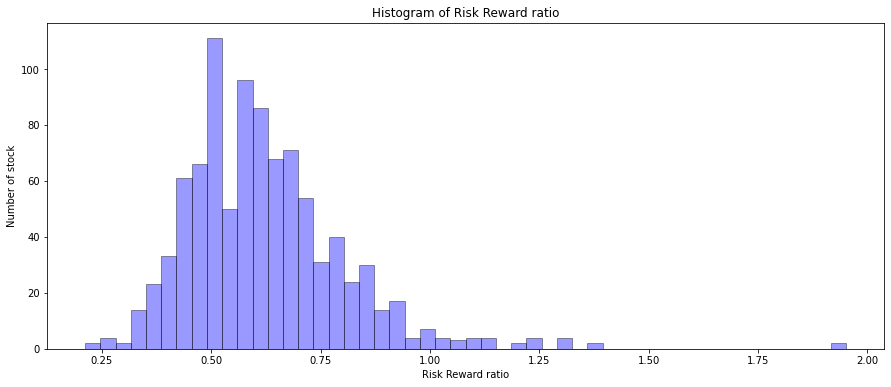

In [110]:
# plot the risk reward ratio
# seaborn histogram
sns.distplot(result_data['Risk Reward ratio'], hist=True, kde=False, 
             bins=int(250/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Risk Reward ratio')
plt.ylabel('Number of stock')
plt.xlabel('Risk Reward ratio')
print(result_data['Risk Reward ratio'].mean())